# 1 min data

In [118]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [131]:

root_dir = './data/one_min_data/'

def read_stock_data(stock_ticker):
    stock_dir = os.path.join(root_dir, stock_ticker)
    stock_files = os.listdir(stock_dir)
    df = pd.DataFrame()
    for stock_file in stock_files:
        stock_full_path = os.path.join(stock_dir, stock_file)
        df_csv = pd.read_csv(stock_full_path, index_col=0)
        df = pd.concat([df, df_csv])

    df['stock_id'] = stock_ticker
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values(by="timestamp", ascending=True)
    df = df.reset_index(drop=True)
    df = df.set_index('timestamp')
    return df


In [159]:
df_stock = read_stock_data('AAPL')
df_stock

,open,high,low,close,volume,stock_id
timestamp,,,,,,
2000-01-03 09:30:00,0.796,0.798,0.795,0.797,3662400,AAPL
2000-01-03 09:31:00,0.797,0.801,0.795,0.796,1456000,AAPL
2000-01-03 09:32:00,0.796,0.800,0.795,0.798,4020800,AAPL
2000-01-03 09:33:00,0.797,0.800,0.793,0.797,4065600,AAPL
2000-01-03 09:34:00,0.797,0.799,0.792,0.793,8870400,AAPL
...,...,...,...,...,...,...
2023-07-20 19:55:00,192.700,192.720,192.660,192.690,1473,AAPL
2023-07-20 19:56:00,192.670,192.720,192.650,192.650,1011,AAPL
2023-07-20 19:57:00,192.650,192.730,192.640,192.690,1180,AAPL


In [174]:
df_stock_close = df_stock['close'].to_frame()
df_stock_close

,close
timestamp,
2000-01-03 09:30:00,0.797
2000-01-03 09:31:00,0.796
2000-01-03 09:32:00,0.798
2000-01-03 09:33:00,0.797
2000-01-03 09:34:00,0.793
...,...
2023-07-20 19:55:00,192.690
2023-07-20 19:56:00,192.650
2023-07-20 19:57:00,192.690


In [177]:
df_stock_close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3584433 entries, 2000-01-03 09:30:00 to 2023-07-20 19:59:00
Data columns (total 1 columns):
 #   Column  Dtype  
---  ------  -----  
 0   close   float64
dtypes: float64(1)
memory usage: 54.7 MB


In [192]:
# realized_volatility
def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))

def log_return(list_stock_prices):
    # pandas dataframe diff() calculates the difference of a DataFrame element compared with another element in the DataFrame (default is element in previous row)
    return np.log(list_stock_prices).diff() 

def calculate_log_return(df_log_return_orig, columns):
    df_log_return = df_log_return_orig.copy()
    for column in columns:
        df_log_return[column + '_log'] = log_return(df_log_return[column])

    return df_log_return

def calculate_realized_volatility(df_rv_orig, columns, time_group):
    df_rv = df_rv_orig.copy()
    for column in columns:
        df_rv[column + '_rv'] = df_rv[column].resample(time_group).apply(realized_volatility)

    df_rv = df_rv.resample(time_group).sum(numeric_only=True)
        
    return df_rv

def make_realized_volatility(df_rv, columns, time_group):
    df_rv = calculate_log_return(df_rv, columns)
    log_columns = [c + '_log' for c in columns]
    df_rv = calculate_realized_volatility(df_rv, log_columns, time_group)
    return df_rv

In [190]:
one_date = datetime.date(2000,1,3)
df_stock_mini_one_day = df_stock_close[df_stock_close.index.date == one_date]
df_stock_mini_one_day

,close
timestamp,
2000-01-03 09:30:00,0.797
2000-01-03 09:31:00,0.796
2000-01-03 09:32:00,0.798
2000-01-03 09:33:00,0.797
2000-01-03 09:34:00,0.793
...,...
2000-01-03 15:57:00,0.851
2000-01-03 15:58:00,0.848
2000-01-03 15:59:00,0.850


In [193]:
rv_one_day = make_realized_volatility(df_stock_mini_one_day, ['close'], "5min")
rv_one_day

,close,close_log,close_log_rv
timestamp,,,
2000-01-03 09:30:00,3.981,-0.005031,0.005896
2000-01-03 09:35:00,3.949,-0.008866,0.004909
2000-01-03 09:40:00,3.922,0.001271,0.005556
2000-01-03 09:45:00,3.970,0.008855,0.010347
2000-01-03 09:50:00,3.962,-0.003785,0.002822
...,...,...,...
2000-01-03 15:40:00,4.195,-0.001194,0.005461
2000-01-03 15:45:00,4.193,-0.001195,0.004302
2000-01-03 15:50:00,4.196,0.008338,0.004609


In [194]:
rv_all = make_realized_volatility(df_stock_close, ['close'], "5min")
rv_all

,close,close_log,close_log_rv
timestamp,,,
2000-01-03 09:30:00,3.981,-0.005031,0.005896
2000-01-03 09:35:00,3.949,-0.008866,0.004909
2000-01-03 09:40:00,3.922,0.001271,0.005556
2000-01-03 09:45:00,3.970,0.008855,0.010347
2000-01-03 09:50:00,3.962,-0.003785,0.002822
...,...,...,...
2023-07-20 19:35:00,963.720,-0.000986,0.000713
2023-07-20 19:40:00,963.440,-0.000208,0.000180
2023-07-20 19:45:00,963.310,-0.000104,0.000381


In [182]:
# ['close','open','high','low']
df_stock_mini = calculate_log_return(df_stock_mini_one_day, ['close'])
df_stock_mini

,close,close_log
timestamp,,
2000-01-03 09:30:00,0.797,NaN
2000-01-03 09:31:00,0.796,-0.001255
2000-01-03 09:32:00,0.798,0.002509
2000-01-03 09:33:00,0.797,-0.001254
2000-01-03 09:34:00,0.793,-0.005031
...,...,...
2000-01-03 15:57:00,0.851,-0.001174
2000-01-03 15:58:00,0.848,-0.003531
2000-01-03 15:59:00,0.850,0.002356


In [183]:
# ['close_log_return', 'open_log_return','high_log_return','low_log_return']
df_stock_mini = calculate_realized_volatility(df_stock_mini, ['close_log'], "5min")
df_stock_mini

,close,close_log,close_log_rv
timestamp,,,
2000-01-03 09:30:00,3.981,-0.005031,0.005896
2000-01-03 09:35:00,3.949,-0.008866,0.004909
2000-01-03 09:40:00,3.922,0.001271,0.005556
2000-01-03 09:45:00,3.970,0.008855,0.010347
2000-01-03 09:50:00,3.962,-0.003785,0.002822
...,...,...,...
2000-01-03 15:40:00,4.195,-0.001194,0.005461
2000-01-03 15:45:00,4.193,-0.001195,0.004302
2000-01-03 15:50:00,4.196,0.008338,0.004609


In [198]:
# plt.plot(df_stock_mini['timestamp'], df_stock_mini['close'])
def draw_line_plot(x, y, x_label, y_label, title):
    if x is not None:
        plt.plot(x,y)
    else:
        plt.plot(y)
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.show();

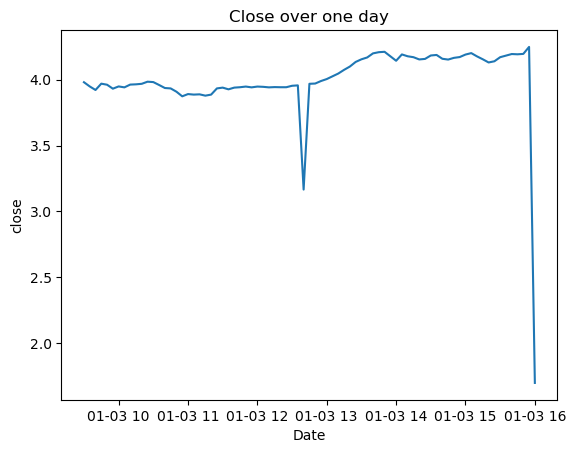

In [202]:
draw_line_plot(rv_one_day.index.values, rv_one_day['close'].values, 'Date', 'close', 'Close over one day')

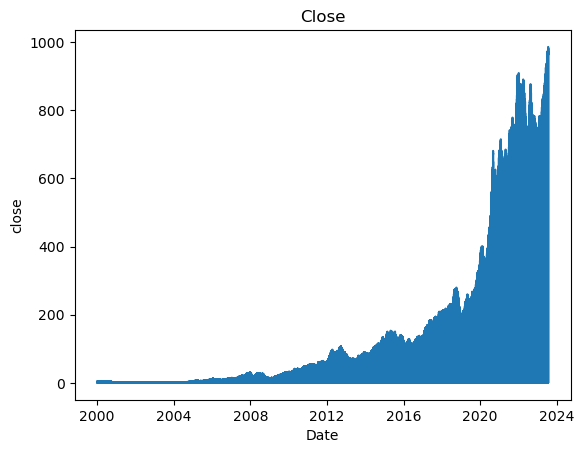

In [199]:
draw_line_plot(rv_all.index.values, rv_all['close'].values, 'Date', 'close', 'Close')

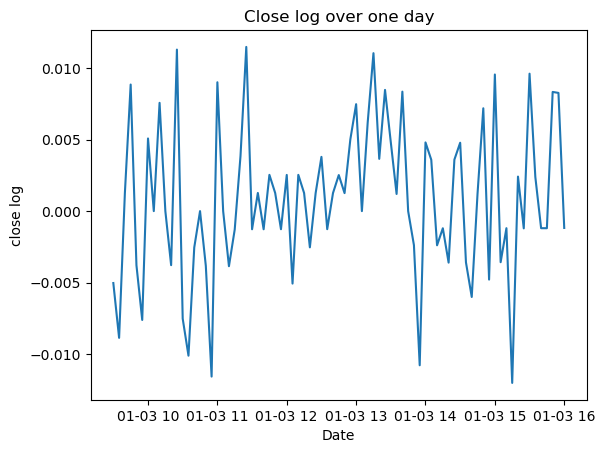

In [203]:
draw_line_plot(rv_one_day.index.values, rv_one_day['close_log'].values, 'Date', 'close log', 'Close log over one day')

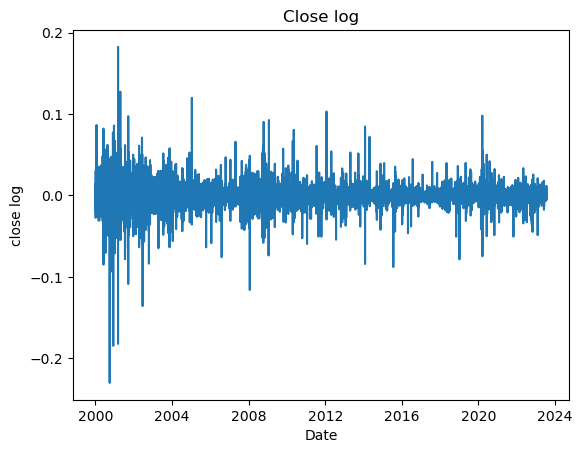

In [200]:
draw_line_plot(rv_all.index.values, rv_all['close_log'].values, 'Date', 'close log', 'Close log')

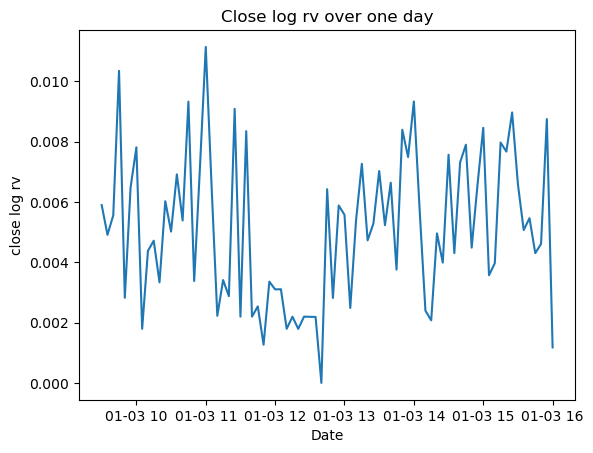

In [204]:
draw_line_plot(rv_one_day.index.values, rv_one_day['close_log_rv'].values, 'Date', 'close log rv', 'Close log rv over one day')

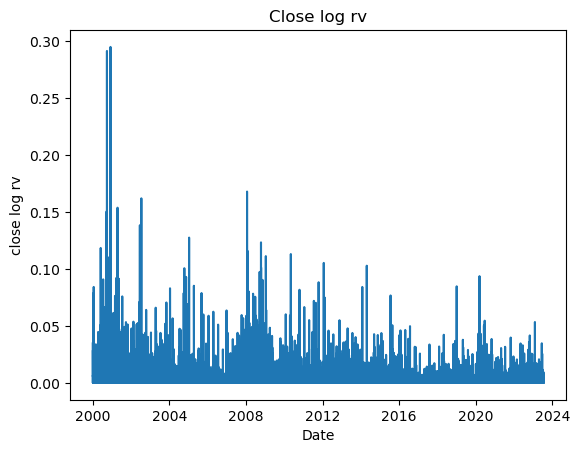

In [205]:
draw_line_plot(rv_all.index.values, rv_all['close_log_rv'].values, 'Date', 'close log rv', 'Close log rv')

In [206]:
rv_all.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2476638 entries, 2000-01-03 09:30:00 to 2023-07-20 19:55:00
Freq: 5T
Data columns (total 3 columns):
 #   Column        Dtype  
---  ------        -----  
 0   close         float64
 1   close_log     float64
 2   close_log_rv  float64
dtypes: float64(3)
memory usage: 75.6 MB
